In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from astropy.io import ascii
from astropy.time import Time
from matplotlib import pyplot as plt
from astropy.coordinates import (AltAz, EarthLocation, SkyCoord, Angle, 
                                 get_sun, get_moon, SkyCoord)

def get_earth_location_and_time(latitude, longitude, height, timezone):
    # SET EARTH LOCATION
    local_coordinates = EarthLocation(lat=latitude, lon=longitude, height=height)
    # SET TIME OF LOCATION
    dt_now = datetime.now(tz=ZoneInfo(timezone))
    local_now = Time(dt_now, location=local_coordinates)
    return local_coordinates, local_now

def create_location_AltAz_timeline(begin_time_ref, end_time_ref, location_time, location_coordinates, N=100):
    timeline = np.linspace(begin_time_ref, end_time_ref, N)*u.hour
    location_timeline = location_time + timeline
    location_timeline_AltAz = AltAz(obstime=location_timeline, location=location_coordinates)
    return location_timeline, location_timeline_AltAz, timeline

def create_sun_and_moon_location_AltAz_timeline(location_timeline, location_timeline_AltAz):
    sun_location_AltAz_timeline = get_sun(location_timeline).transform_to(location_timeline_AltAz)
    moon_location_AltAz_obstime = get_moon(location_timeline).transform_to(location_timeline_AltAz)
    return sun_location_AltAz_timeline, moon_location_AltAz_obstime

def get_location_moon_illumination(location_time):
    sun = get_sun(location_time)
    moon = get_moon(location_time)
    elongation = sun.separation(moon)
    moon_phase_angle = np.arctan2(
        sun.distance*np.sin(elongation), 
        moon.distance - sun.distance*np.cos(elongation)
    )
    moon_illumination = (1 + np.cos(moon_phase_angle))/2.0    
    return moon_illumination

# LOCATION

In [2]:
# DEFINE HERE YOUR GPS COORDINATES
def get_myhome_location_and_time():
    HOME_LAT = -27.480997*u.deg
    HOME_LON = -48.401418*u.deg
    HOME_HEI = 20*u.m
    HOME_TZ = 'America/Sao_Paulo'
    return get_earth_location_and_time(HOME_LAT, HOME_LON, HOME_HEI, HOME_TZ)

# T80-South Location
def get_t80s_location_and_time():
    T80S_LAT = '-30:10:04.31 degrees'
    T80S_LON = '-70:48:20.48 degrees'
    T80S_HEI = 2187
    Chile_timezone = 'America/Santiago'
    t80s_lat = Angle(T80S_LAT)
    t80s_lon = Angle(T80S_LON)
    t80s_hei = T80S_HEI*u.m
    return get_earth_location_and_time(t80s_lat, t80s_lon, t80s_hei, Chile_timezone)

home_coordinates, home_now = get_myhome_location_and_time()
print('home_coordinates: ', home_coordinates)
print('home_now: ', home_now)

home_coordinates:  (3759382.83741384, -4234505.87399877, -2925611.53670425) m
home_now:  2023-05-18 16:12:24.874675


# TIMELINE

In [3]:
# 0 is NOW!
begin_time_ref = -2
end_time_ref = 22
time_label = 'hours [h]'
obstime, home_AltAz_obstime, time_lapse = create_location_AltAz_timeline(
    begin_time_ref=begin_time_ref, 
    end_time_ref=end_time_ref,
    location_time=home_now, 
    location_coordinates=home_coordinates,
    N=100,
)

# GET MOON AND SUN AT LOCATION

In [4]:
sun_AltAz_obstime, moon_AltAz_obstime = create_sun_and_moon_location_AltAz_timeline(
    location_timeline=obstime, 
    location_timeline_AltAz=home_AltAz_obstime
)

home_moon_illumination = get_location_moon_illumination(home_now)

# ADD SOME OTHER OBJECTS

In [5]:
# Get objects from SIMBAD using class astropy.coordinates.SkyCoord
obj1_name = 'Antares'
obj1_home = SkyCoord.from_name(obj1_name)
obj1_AltAz_home_now = obj1_home.transform_to(AltAz(obstime=home_now, location=home_coordinates))
obj1_AltAz_obstime = obj1_AltAz_home_now.transform_to(home_AltAz_obstime)

obj2_name = 'Betelgeuse'
obj2_home = SkyCoord.from_name(obj2_name)
obj2_AltAz_home_now = obj2_home.transform_to(AltAz(obstime=home_now, location=home_coordinates))
obj2_AltAz_obstime = obj2_AltAz_home_now.transform_to(home_AltAz_obstime)

# CREATE A NICE PLOT

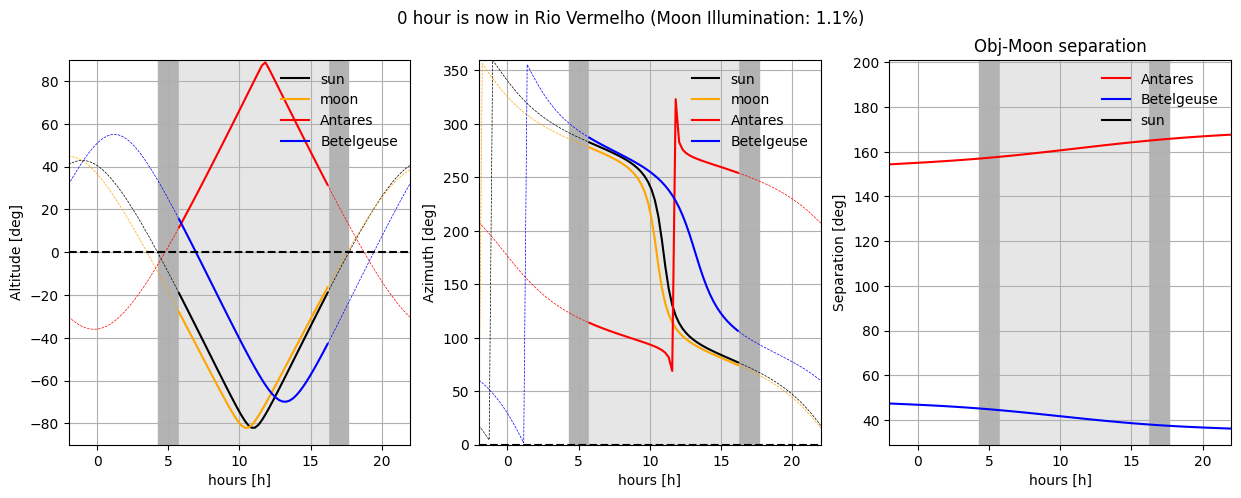

In [6]:
mask_night = sun_AltAz_obstime.alt < -0*u.deg
mask_twilight = sun_AltAz_obstime.alt < -18*u.deg

# PLOT
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(15, 5)
f.suptitle('0 hour is now in Rio Vermelho (Moon Illumination: {:.1f}%)'.format(home_moon_illumination*100))
ax1.plot(time_lapse, sun_AltAz_obstime.alt, color='k', ls='--', lw=0.5)
ax1.plot(time_lapse, moon_AltAz_obstime.alt, color='orange', ls='--', lw=0.5)
ax1.plot(time_lapse, obj1_AltAz_obstime.alt, color='r', ls='--', lw=0.5)
ax1.plot(time_lapse, obj2_AltAz_obstime.alt, color='b', ls='--', lw=0.5)
ax1.plot(time_lapse[mask_twilight], sun_AltAz_obstime.alt[mask_twilight], color='k', label='sun')
ax1.plot(time_lapse[mask_twilight], moon_AltAz_obstime.alt[mask_twilight], color='orange', label='moon')
ax1.plot(time_lapse[mask_twilight], obj1_AltAz_obstime.alt[mask_twilight], color='r', label=obj1_name)
ax1.plot(time_lapse[mask_twilight], obj2_AltAz_obstime.alt[mask_twilight], color='b', label=obj2_name)
ax1.fill_between(time_lapse.value, -90, 90, mask_night, color='0.7', zorder=0)
ax1.fill_between(time_lapse.value, -90, 90, mask_twilight, color='0.9', zorder=0)
ax1.axhline(y=0, ls='--', color='k')
ax1.legend(frameon=False, loc=1)
ax1.set_xlim(begin_time_ref, end_time_ref)
ax1.set_ylim(-90, 90)
ax1.set_xlabel(time_label)
ax1.set_ylabel('Altitude [deg]')
ax1.grid()

ax2.plot(time_lapse, sun_AltAz_obstime.az, color='k', ls='--', lw=0.5)
ax2.plot(time_lapse, moon_AltAz_obstime.az, color='orange', ls='--', lw=0.5)
ax2.plot(time_lapse, obj1_AltAz_obstime.az, color='r', ls='--', lw=0.5)
ax2.plot(time_lapse, obj2_AltAz_obstime.az, color='b', ls='--', lw=0.5)
ax2.plot(time_lapse[mask_twilight], sun_AltAz_obstime.az[mask_twilight], color='k', label='sun')
ax2.plot(time_lapse[mask_twilight], moon_AltAz_obstime.az[mask_twilight], color='orange', label='moon')
ax2.plot(time_lapse[mask_twilight], obj1_AltAz_obstime.az[mask_twilight], color='r', label=obj1_name)
ax2.plot(time_lapse[mask_twilight], obj2_AltAz_obstime.az[mask_twilight], color='b', label=obj2_name)
ax2.fill_between(time_lapse.value, 0, 360, mask_night, color='0.7', zorder=0)
ax2.fill_between(time_lapse.value, 0, 360, mask_twilight, color='0.9', zorder=0)
ax2.axhline(y=0, ls='--', color='k')
ax2.legend(frameon=False, loc=1)
ax2.set_xlim(begin_time_ref, end_time_ref)
ax2.set_ylim(0, 360)
ax2.set_xlabel(time_label)
ax2.set_ylabel('Azimuth [deg]')
ax2.grid()

ax3.set_title('Moon Illumination = {:.2f}%'.format(100*home_moon_illumination))
_sep = obj1_AltAz_obstime.separation(moon_AltAz_obstime)
_sep2 = obj2_AltAz_obstime.separation(moon_AltAz_obstime)
_sep3 = sun_AltAz_obstime.separation(moon_AltAz_obstime)
ax3.plot(time_lapse, _sep, color='r', label=obj1_name)
ax3.plot(time_lapse, _sep2, color='b', label=obj2_name)
ax3.plot(time_lapse, _sep3, color='k', label='sun')
_range = [min(_sep.value), max(_sep.value)]
if max(_sep2.value) > _range[1]:
    _range[1] = max(_sep2.value)
if min(_sep2.value) < _range[0]:
    _range[0] = min(_sep2.value)
ax3.fill_between(time_lapse.value, 0, 360, mask_night, color='0.7', zorder=0)
ax3.fill_between(time_lapse.value, 0, 360, mask_twilight, color='0.9', zorder=0)
ax3.set_xlabel(time_label)
ax3.set_title('Obj-Moon separation')
ax3.set_ylabel('Separation [deg]')
ax3.set_xlim(begin_time_ref, end_time_ref)
ax3.set_ylim(_range[0]*0.8, _range[1]*1.2)
ax3.grid()
ax3.legend(frameon=False, loc=1)
f.savefig('objects_in_sky_HOME.pdf')

In [7]:
# OBJECTS POSITION AT LOCATION NOW
print(f'{obj1_name} Alt now: {obj1_AltAz_obstime.alt[0]:.2f}')
print(f'{obj1_name} Az now: {obj1_AltAz_obstime.az[0]:.2f}')
print(f'{obj2_name} Alt now: {obj2_AltAz_obstime.alt[0]:.2f}')
print(f'{obj2_name} Az now: {obj2_AltAz_obstime.az[0]:.2f}')

Antares Alt now: -30.11 deg
Antares Az now: 208.02 deg
Betelgeuse Alt now: 31.64 deg
Betelgeuse Az now: 60.57 deg


# MOON AND SUN NOW AT T80-SOUTH SKY

In [8]:
t80s_coordinates, t80s_now = get_t80s_location_and_time()
begin_time_ref = 0
end_time_ref = 24
time_label = 'hours [h]'
obstime, t80s_AltAz_obstime, next_24h = create_location_AltAz_timeline(
    begin_time_ref=begin_time_ref, 
    end_time_ref=end_time_ref,
    location_time=t80s_now, 
    location_coordinates=t80s_coordinates
)

sun_AltAz_obstime, moon_AltAz_obstime = create_sun_and_moon_location_AltAz_timeline(
    location_timeline=obstime, 
    location_timeline_AltAz=t80s_AltAz_obstime
)

t80s_moon_illumination = get_location_moon_illumination(t80s_now)

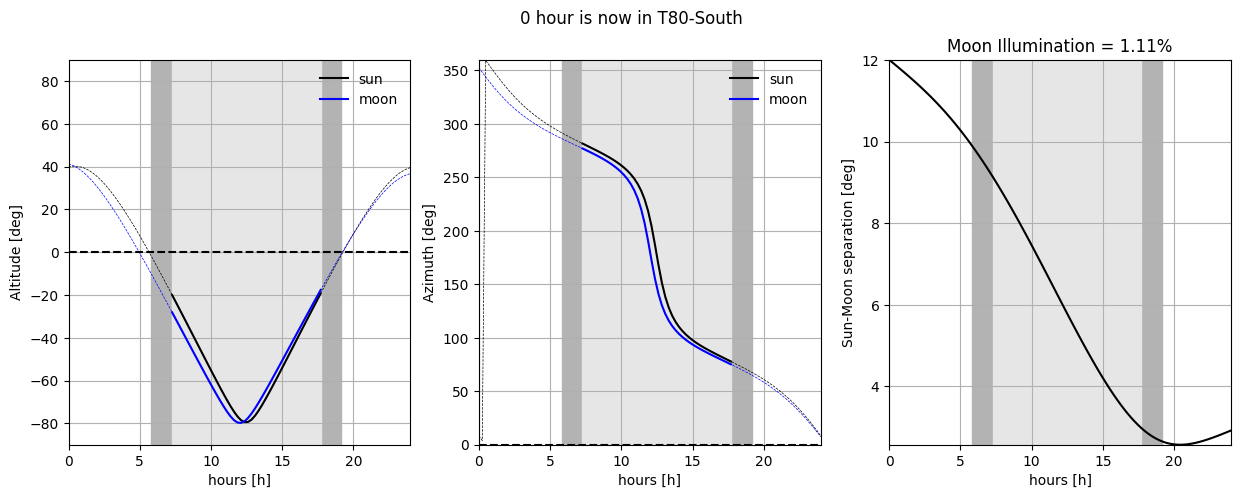

In [9]:
mask_night = sun_AltAz_obstime.alt < -0*u.deg
mask_twilight = sun_AltAz_obstime.alt < -18*u.deg

# PLOT
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(15, 5)
f.suptitle('0 hour is now in T80-South')
ax1.plot(next_24h, sun_AltAz_obstime.alt, color='k', ls='--', lw=0.5)
ax1.plot(next_24h, moon_AltAz_obstime.alt, color='b', ls='--', lw=0.5)
ax1.plot(next_24h[mask_twilight], sun_AltAz_obstime.alt[mask_twilight], color='k', label='sun')
ax1.plot(next_24h[mask_twilight], moon_AltAz_obstime.alt[mask_twilight], color='b', label='moon')
ax1.fill_between(next_24h/u.h, -90, 90, mask_night, color='0.7', zorder=0)
ax1.fill_between(next_24h/u.h, -90, 90, mask_twilight, color='0.9', zorder=0)
ax1.axhline(y=0, ls='--', color='k')
ax1.legend(frameon=False, loc=1)
ax1.set_xlim(begin_time_ref, end_time_ref)
ax1.set_ylim(-90, 90)
ax1.set_xlabel(time_label)
ax1.set_ylabel('Altitude [deg]')
ax1.grid()

ax2.plot(next_24h, sun_AltAz_obstime.az, color='k', ls='--', lw=0.5)
ax2.plot(next_24h, moon_AltAz_obstime.az, color='b', ls='--', lw=0.5)
ax2.plot(next_24h[mask_twilight], sun_AltAz_obstime.az[mask_twilight], color='k', label='sun')
ax2.plot(next_24h[mask_twilight], moon_AltAz_obstime.az[mask_twilight], color='b', label='moon')
ax2.fill_between(next_24h/u.h, 0, 360, mask_night, color='0.7', zorder=0)
ax2.fill_between(next_24h/u.h, 0, 360, mask_twilight, color='0.9', zorder=0)
ax2.axhline(y=0, ls='--', color='k')
ax2.legend(frameon=False, loc=1)
ax2.set_xlim(begin_time_ref, end_time_ref)
ax2.set_ylim(0, 360)
ax2.set_xlabel(time_label)
ax2.set_ylabel('Azimuth [deg]')
ax2.grid()

ax3.set_title('Moon Illumination = {:.2f}%'.format(100*t80s_moon_illumination))
_sep = sun_AltAz_obstime.separation(moon_AltAz_obstime)
ax3.plot(next_24h, _sep, color='k')
_range = min(_sep.value), max(_sep.value)
ax3.fill_between(next_24h.value, min(_sep.value), max(_sep.value), mask_night, color='0.7', zorder=0)
ax3.fill_between(next_24h.value, min(_sep.value), max(_sep.value), mask_twilight, color='0.9', zorder=0)
ax3.set_xlabel(time_label)
ax3.set_ylabel('Sun-Moon separation [deg]')
ax3.set_xlim(begin_time_ref, end_time_ref)
ax3.set_ylim(_range)
ax3.grid()
f.savefig('sun_and_moon_today_in_t80s.pdf')